# Latents of MODIS_R2019_2010

In [2]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [3]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename

import pandas

import h5py
import seaborn as sns
import pandas as pd
#import umap
from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.ssl.train_util import modis_loader, set_model
from ulmo.ssl.train_util import Params, option_preprocess
from ulmo.ssl import latents_extraction

import torch

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [4]:
llc_modis_2012_data_path = "/home/jovyan/ulmo/ulmo/runs/SSL/experiments/datasets/llc_dataset/"
llc_modis_2012_data = os.path.join(llc_modis_2012_data_path, os.listdir(llc_modis_2012_data_path)[0])

In [5]:
with h5py.File(llc_modis_2012_data, 'r') as f:
    llc_modis_2012 = f['valid'][:]

In [6]:
print(llc_modis_2012.shape)

(635295, 1, 64, 64)


In [8]:
llc_modis_2012_latents_path = "/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl/experiments/LLC_MODIS_2012_latents/"
llc_modis_2012_latents = os.path.join(llc_modis_2012_latents_path, os.listdir(llc_modis_2012_latents_path)[0])

In [15]:
with h5py.File(llc_modis_2012_latents, 'r') as f:
    latents_llc_modis_2012 = f['valid'][:]

In [24]:
latents_llc_modis_2012.shape
num_samples = latents_llc_modis_2012.shape[0]

In [17]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents_llc_modis_2012)
### Transform the latents
latents_std = scaler.transform(latents_llc_modis_2012)

In [18]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

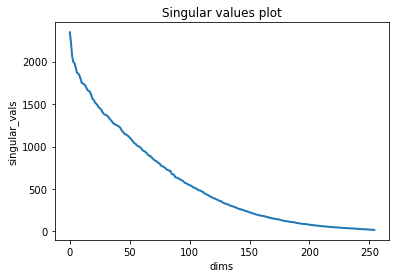

In [19]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

In [21]:
import umap

In [22]:
%%time 
reducer_umap = umap.UMAP()
latents_reduced = reducer_umap.fit_transform(latents_std)

CPU times: user 2h 14min 45s, sys: 37min 56s, total: 2h 52min 41s
Wall time: 30min 34s


In [23]:
### Store the latents
latents_umap_file = 'latents_umap_epoch_5.h5'
latents_umap_path = os.path.join(llc_modis_2012_latents_path, latents_umap_file)
save_key = 'latents_umap'
with h5py.File(latents_umap_path, 'w') as file:
    file.create_dataset(save_key, data=latents_reduced)

In [9]:
### read the latents
latents_umap_file = 'latents_umap_epoch_5.h5'
latents_umap_path = os.path.join(llc_modis_2012_latents_path, latents_umap_file)
save_key = 'latents_umap'
with h5py.File(latents_umap_path, 'r') as file:
    latents_reduced = file[save_key][:]

In [23]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 24min 50s, sys: 2min 43s, total: 27min 33s
Wall time: 14min


In [24]:
import umap.plot

<AxesSubplot:>

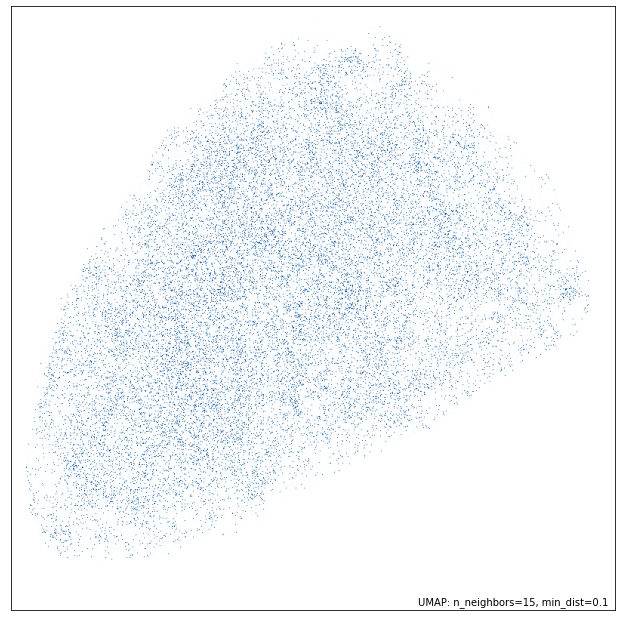

In [25]:
umap.plot.points(latents_mapping)

<AxesSubplot:>

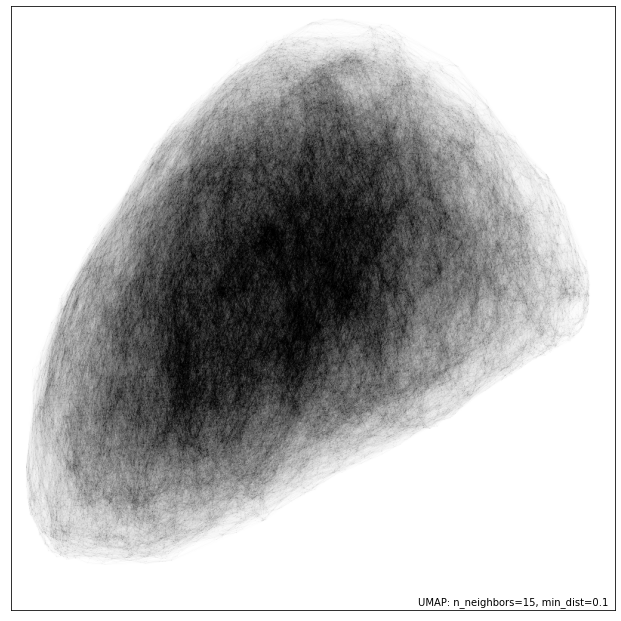

In [26]:
umap.plot.connectivity(latents_mapping, show_points=False)

-----------------------------------------------

## Show the latents with the cutouts

In [25]:
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

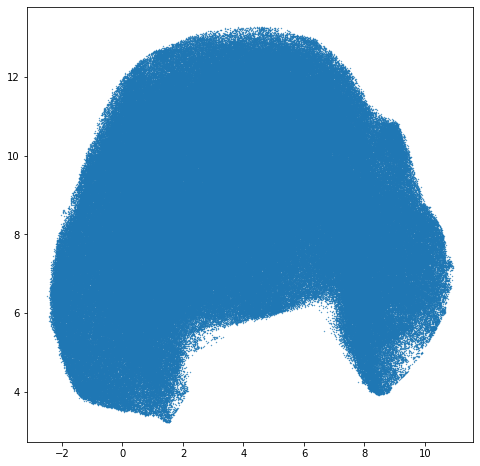

In [15]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)

In [13]:
from sklearn.neighbors import NearestNeighbors

In [14]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(latents_reduced)
distances, indices = nbrs.kneighbors(latents_reduced)

In [16]:
### fix seed
np.random.seed(0)
indice_sampled = np.random.choice(indices.shape[0], 5)
indice_sets = indices[indice_sampled]
dist_sets = distances[indice_sampled]

In [20]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

## Show the set 1

In [18]:
imgs_set = llc_modis_2012[indice_sets[0]]
dist_set = dist_sets[0]

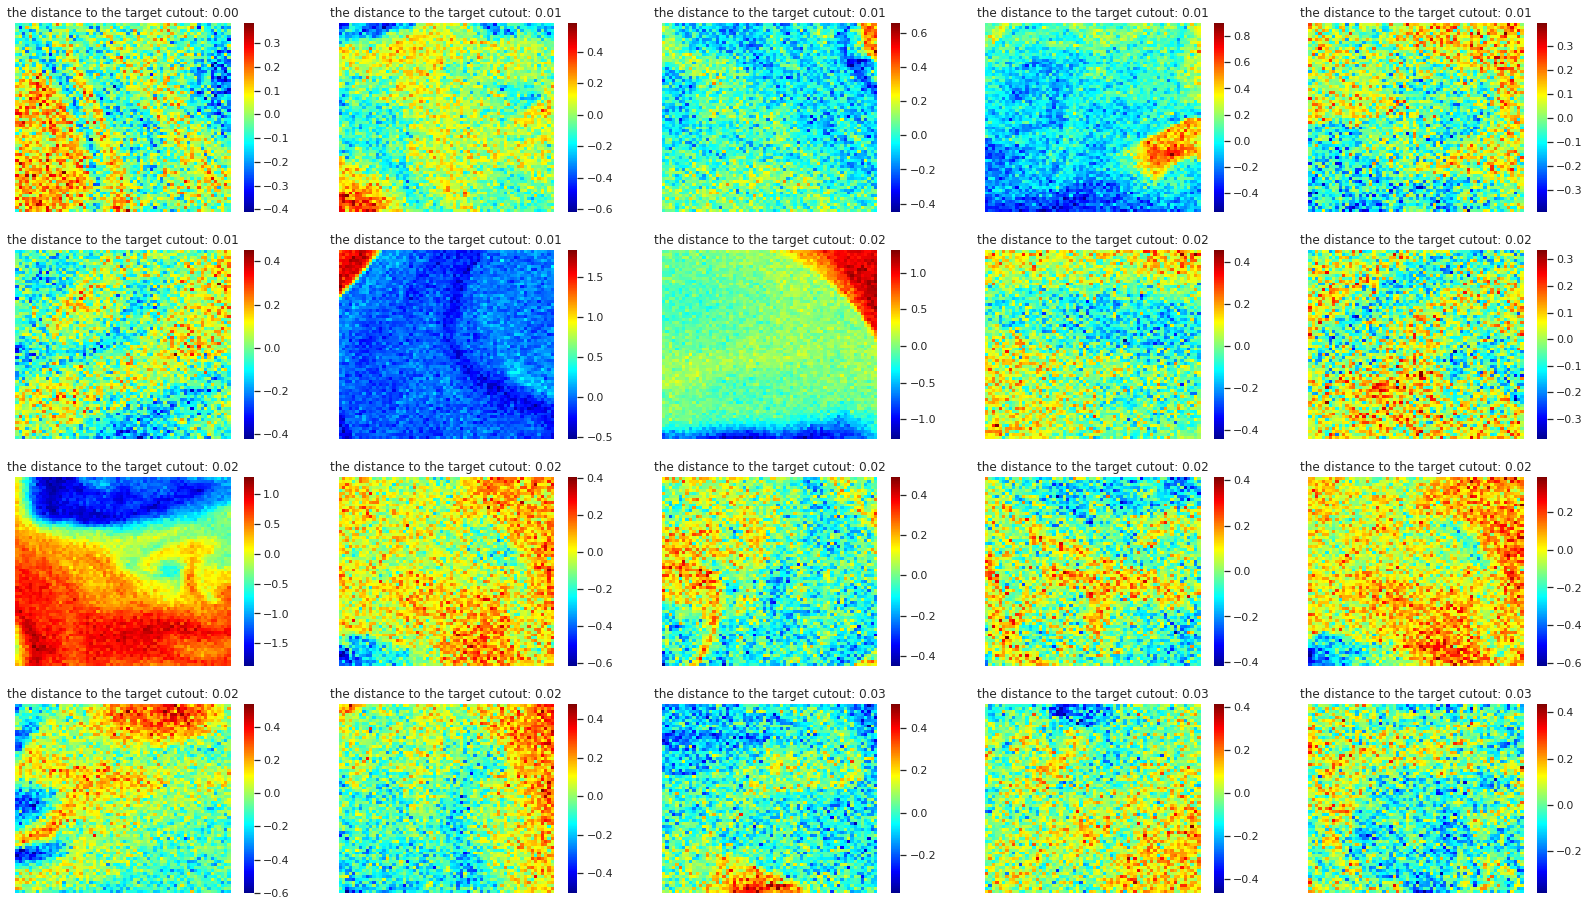

In [21]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 2

In [22]:
imgs_set = llc_modis_2012[indice_sets[1]]
dist_set = dist_sets[1]

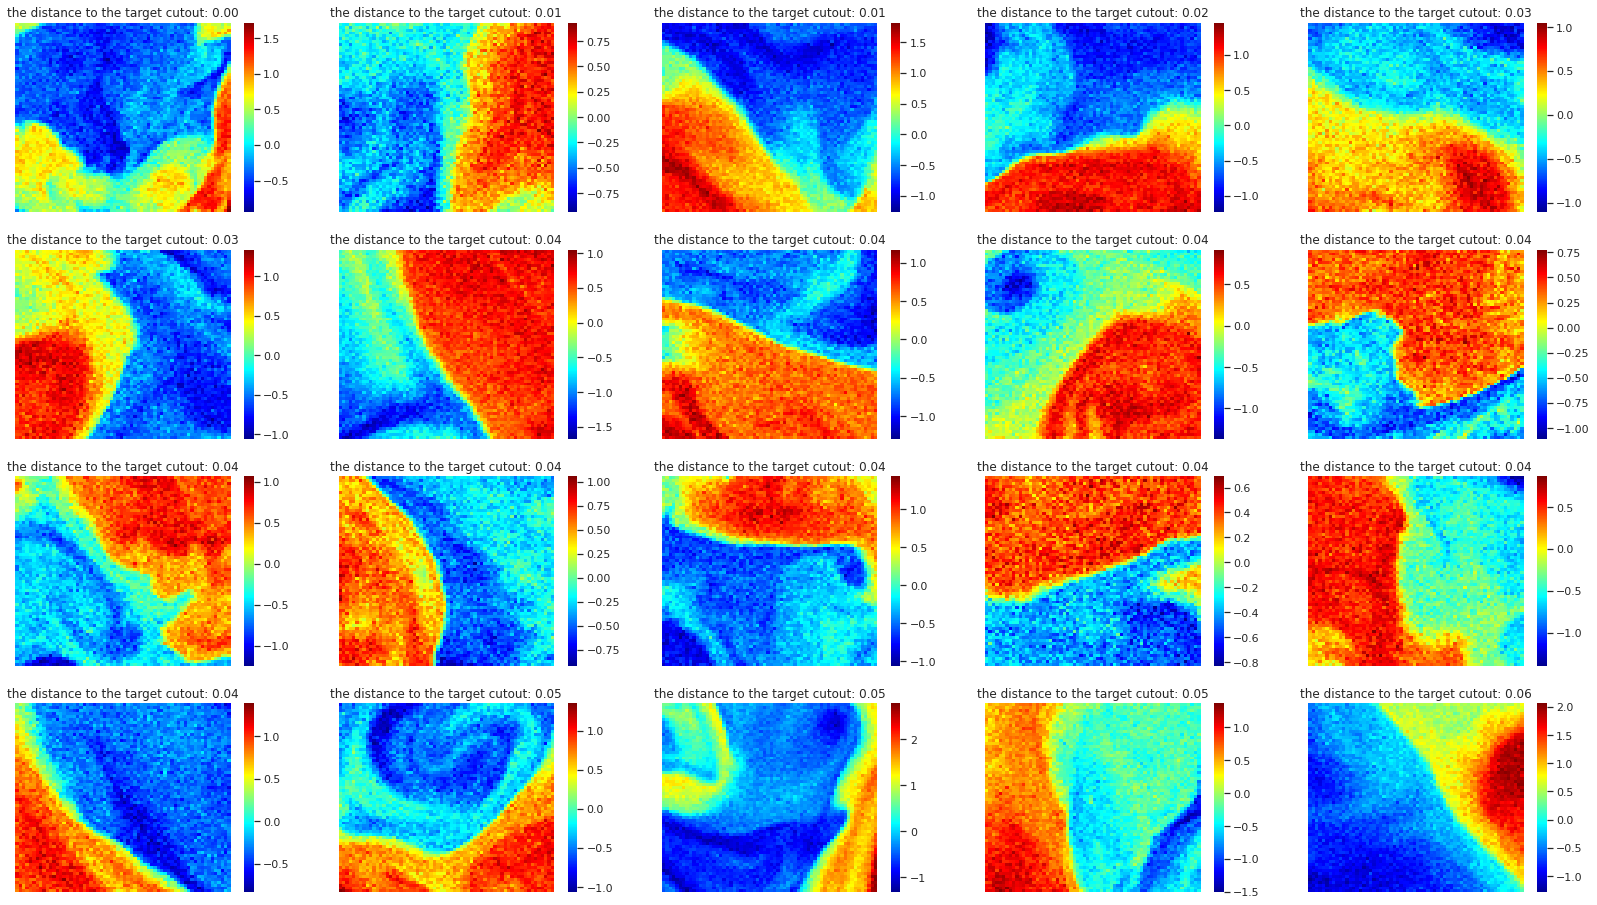

In [23]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 3

In [24]:
imgs_set = llc_modis_2012[indice_sets[2]]
dist_set = dist_sets[2]

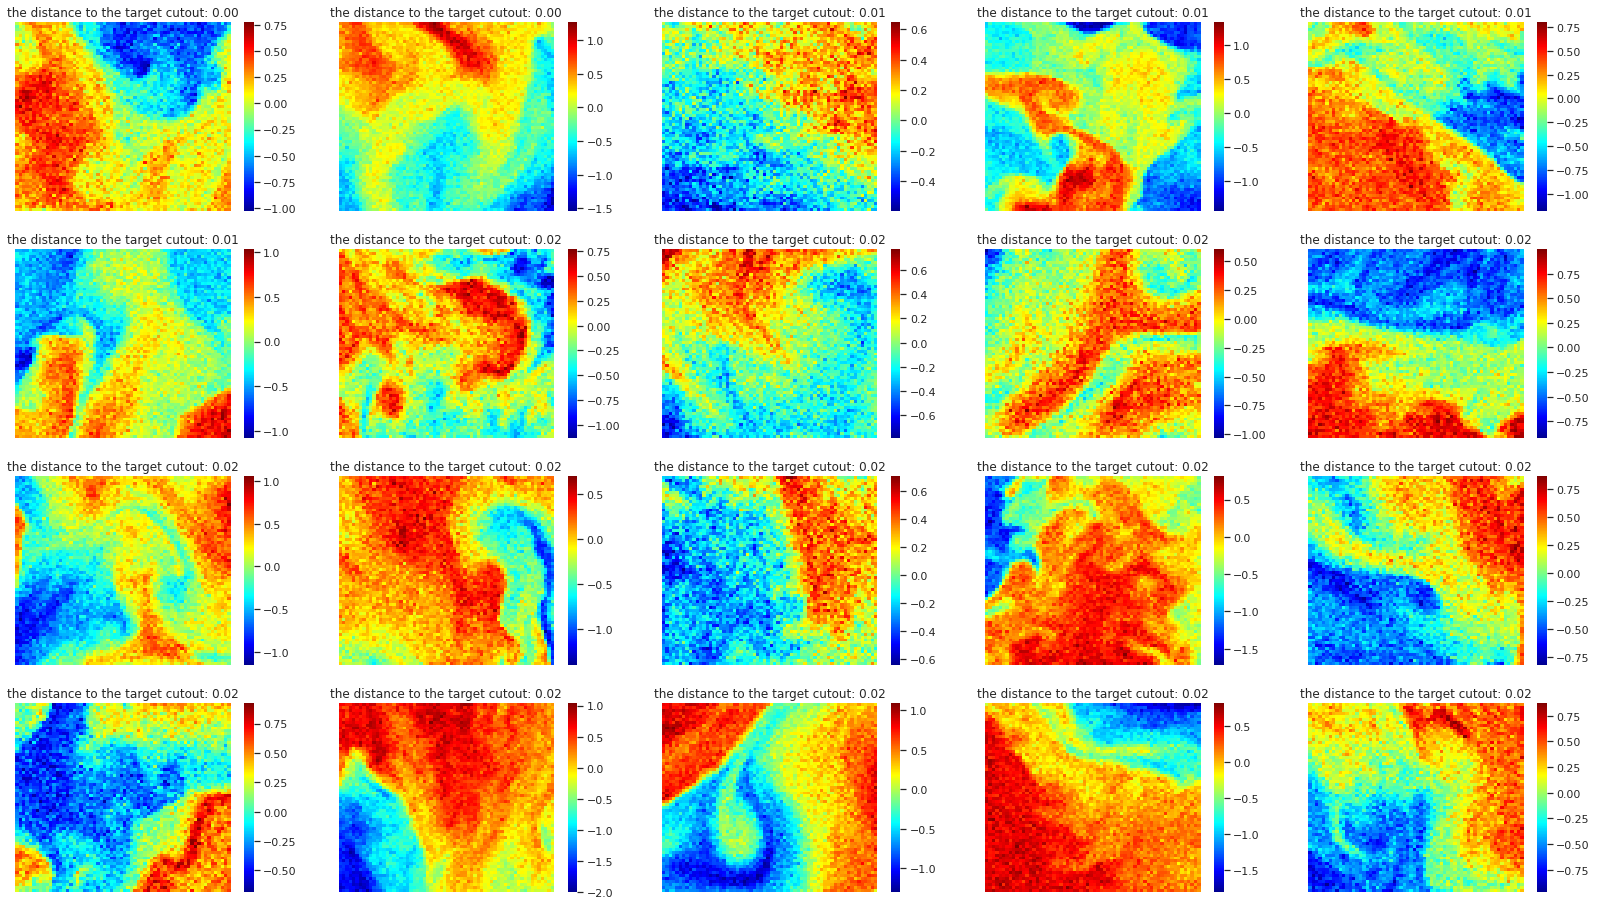

In [25]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 4

In [26]:
imgs_set = llc_modis_2012[indice_sets[3]]
dist_set = dist_sets[3]

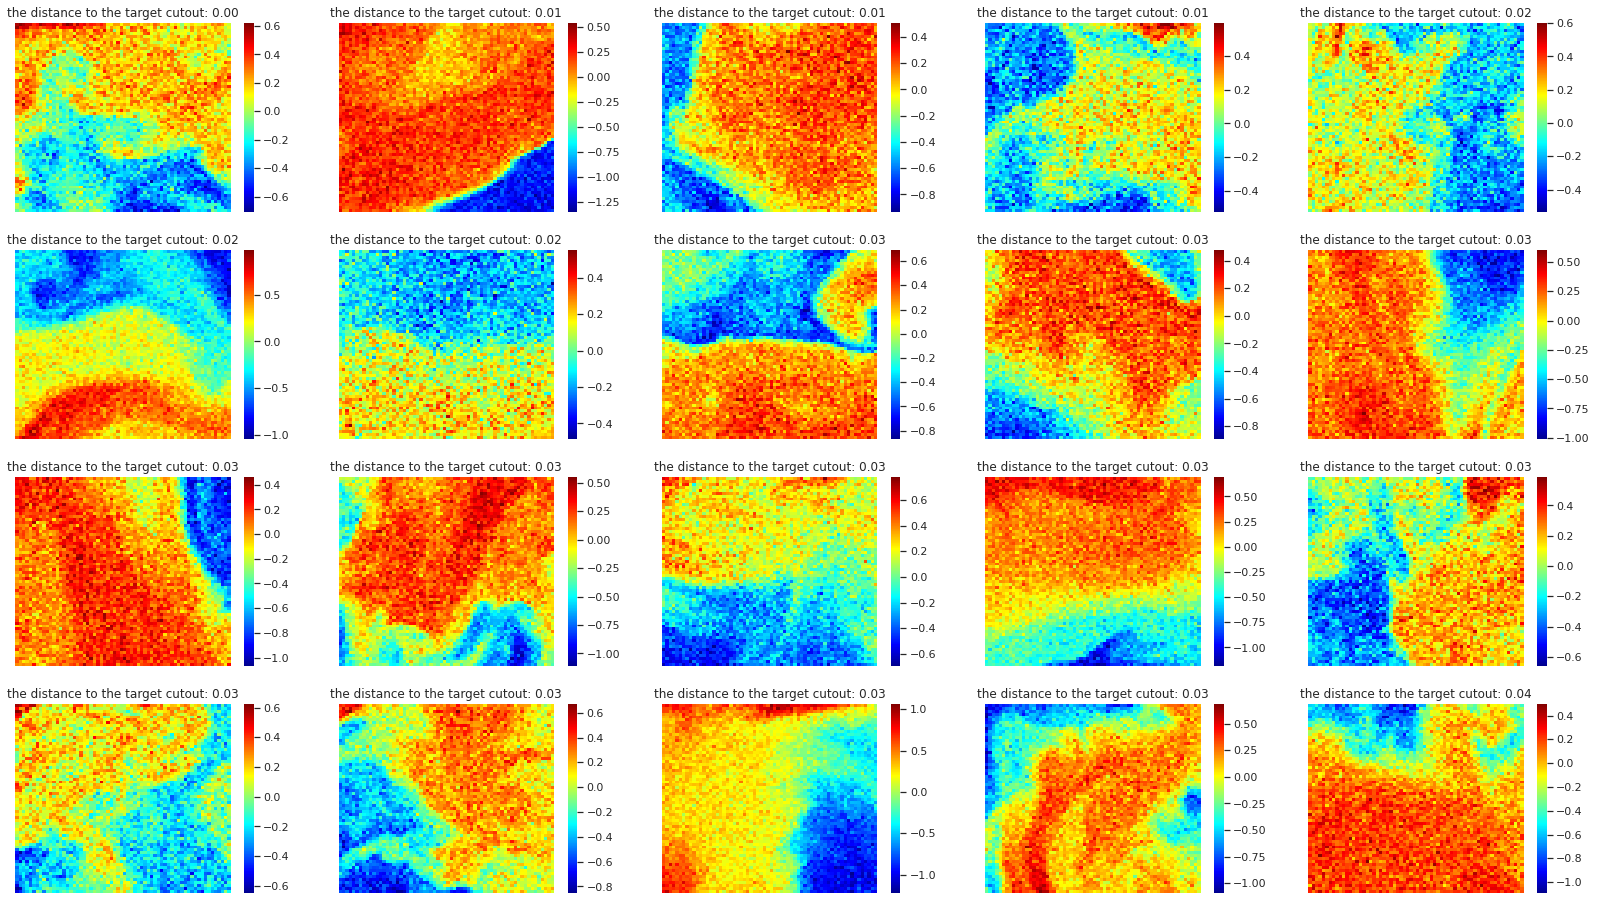

In [27]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 5

In [28]:
imgs_set = llc_modis_2012[indice_sets[4]]
dist_set = dist_sets[4]

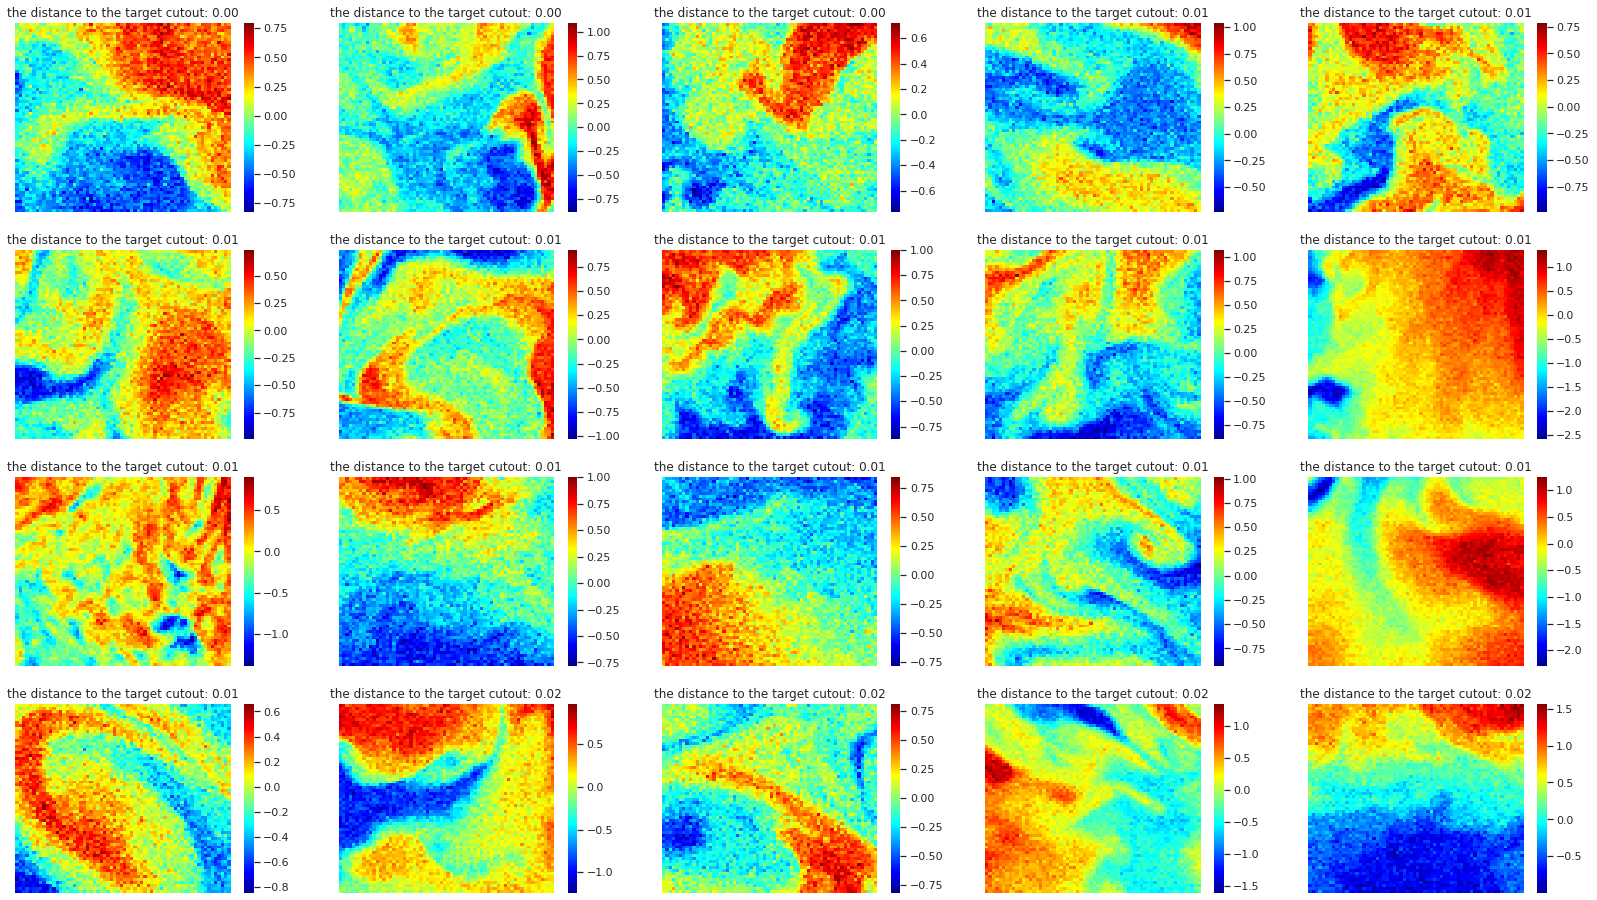

In [29]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

# Show the Scatter plot with cutouts

In [3]:
### Store the latents
save_path = './experiments/modis_R2019_latents_last.h5'
save_key = 'latents_train'
with h5py.File(save_path, 'r') as file:
    latents_reduced = file[save_key][:]

In [10]:
num_samples = latents_reduced.shape[0]
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

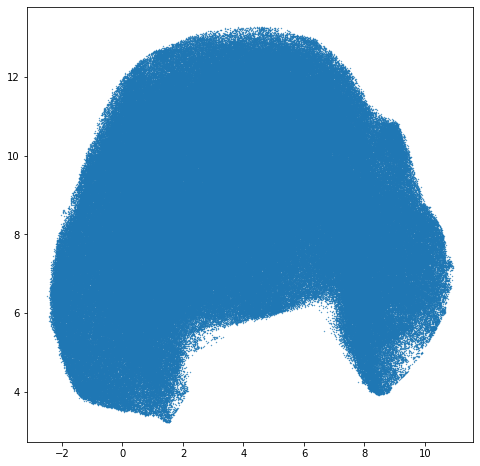

In [11]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)

In [30]:
latents_list = [latents_reduced[i, :] for i in indice_sets[0]]

In [31]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [32]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [33]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

In [34]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.patches import Rectangle
from matplotlib.cbook import get_sample_data

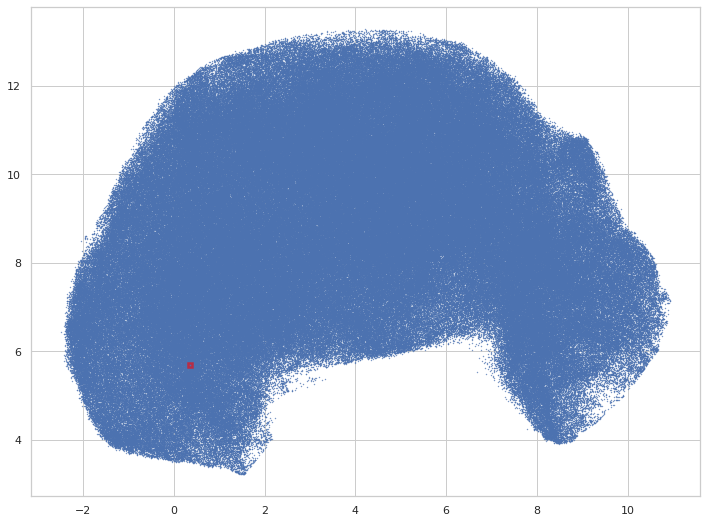

In [37]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(12, 9))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        2*len_square, 2*height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

In [39]:
imgs_set = llc_modis_2012[indice_sets[0]]
dist_set = dist_sets[0]

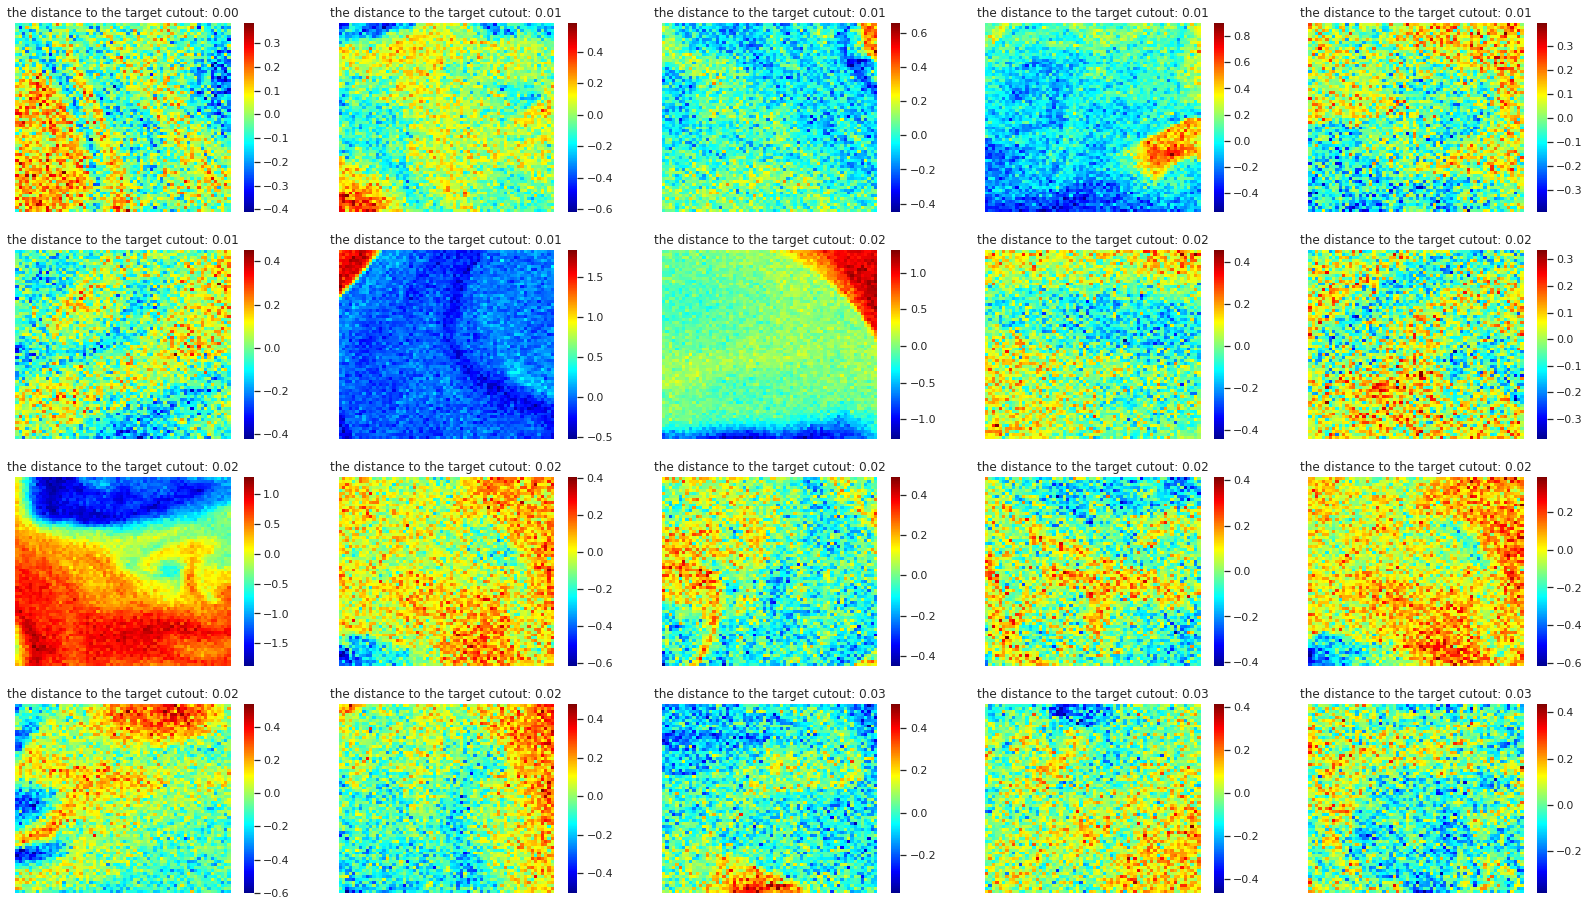

In [40]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [42]:
imgs_set = llc_modis_2012[indice_sets[1]]
dist_set = dist_sets[1]

In [43]:
latents_list = [latents_reduced[i, :] for i in indice_sets[1]]

In [44]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [45]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [46]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

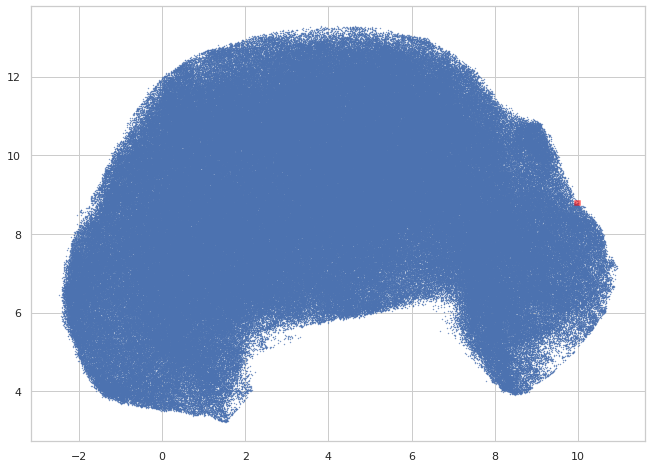

In [48]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

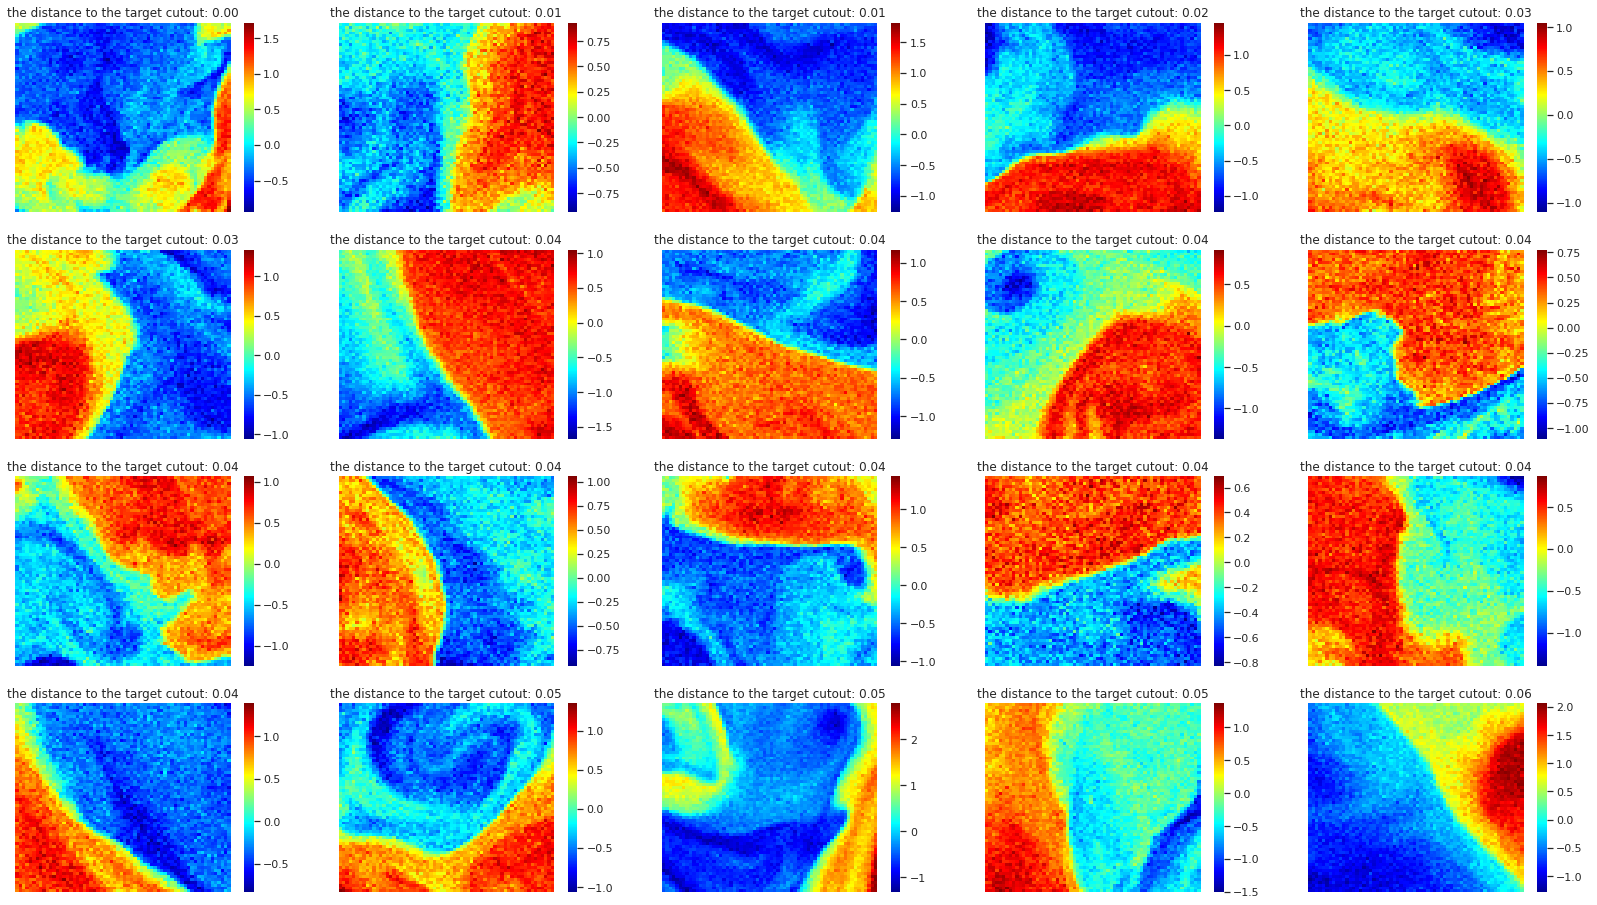

In [49]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [50]:
imgs_set = llc_modis_2012[indice_sets[2]]
dist_set = dist_sets[2]

In [51]:
latents_list = [latents_reduced[i, :] for i in indice_sets[2]]

In [52]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [53]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [54]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

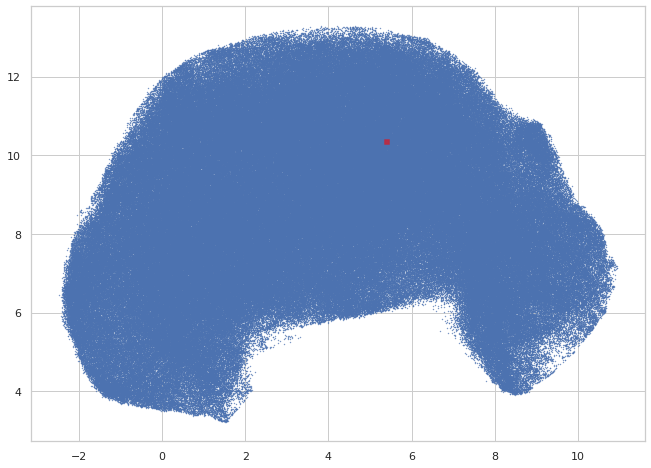

In [56]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        2*len_square, 2*height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

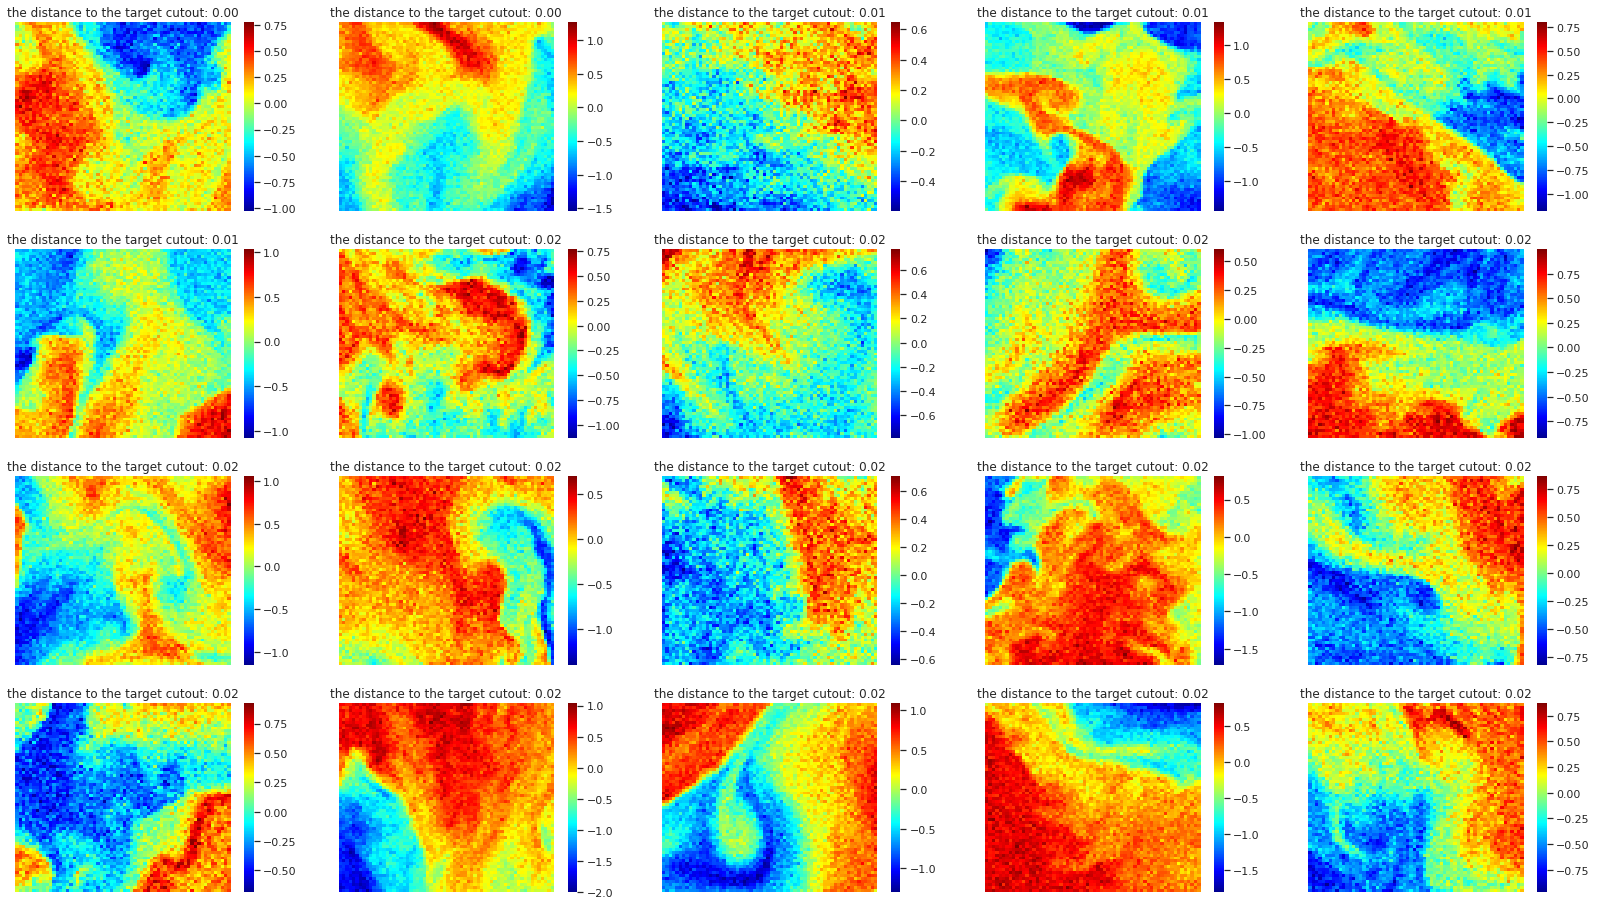

In [57]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [58]:
imgs_set = llc_modis_2012[indice_sets[3]]
dist_set = dist_sets[3]

In [59]:
latents_list = [latents_reduced[i, :] for i in indice_sets[3]]

In [60]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [61]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [62]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

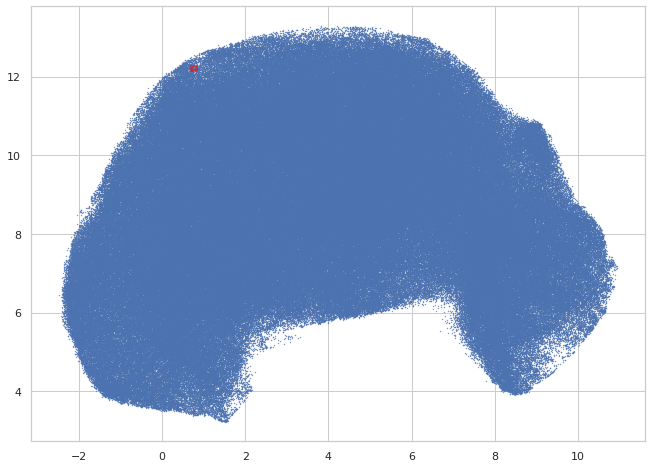

In [64]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        2*len_square, 2*height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

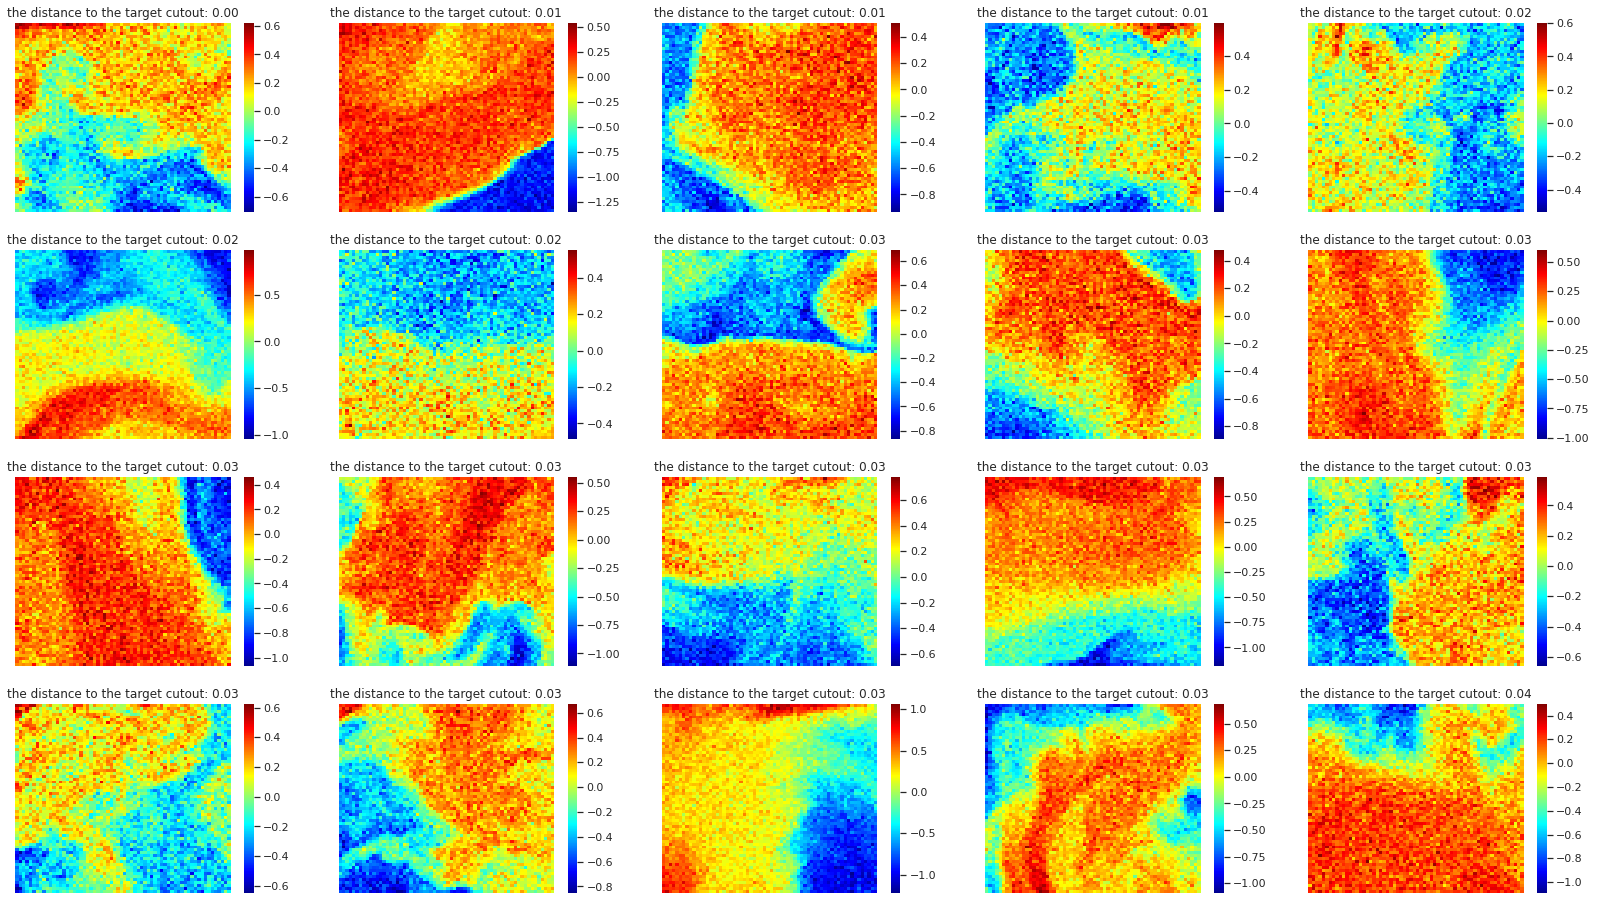

In [65]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [66]:
imgs_set = llc_modis_2012[indice_sets[4]]
dist_set = dist_sets[4]

In [67]:
latents_list = [latents_reduced[i, :] for i in indice_sets[4]]

In [68]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [69]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [70]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

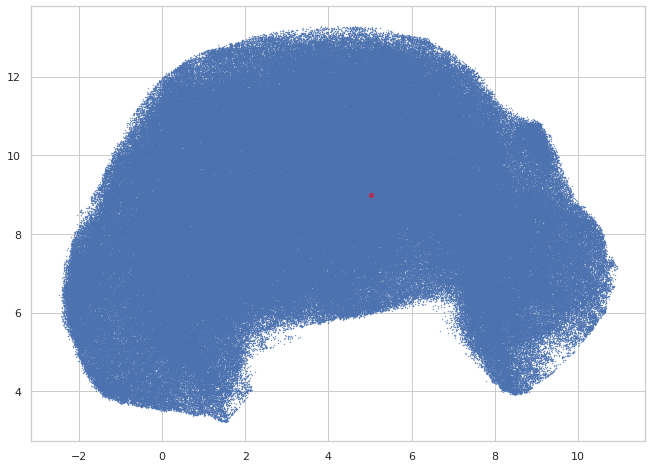

In [72]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        2*len_square, 2*height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

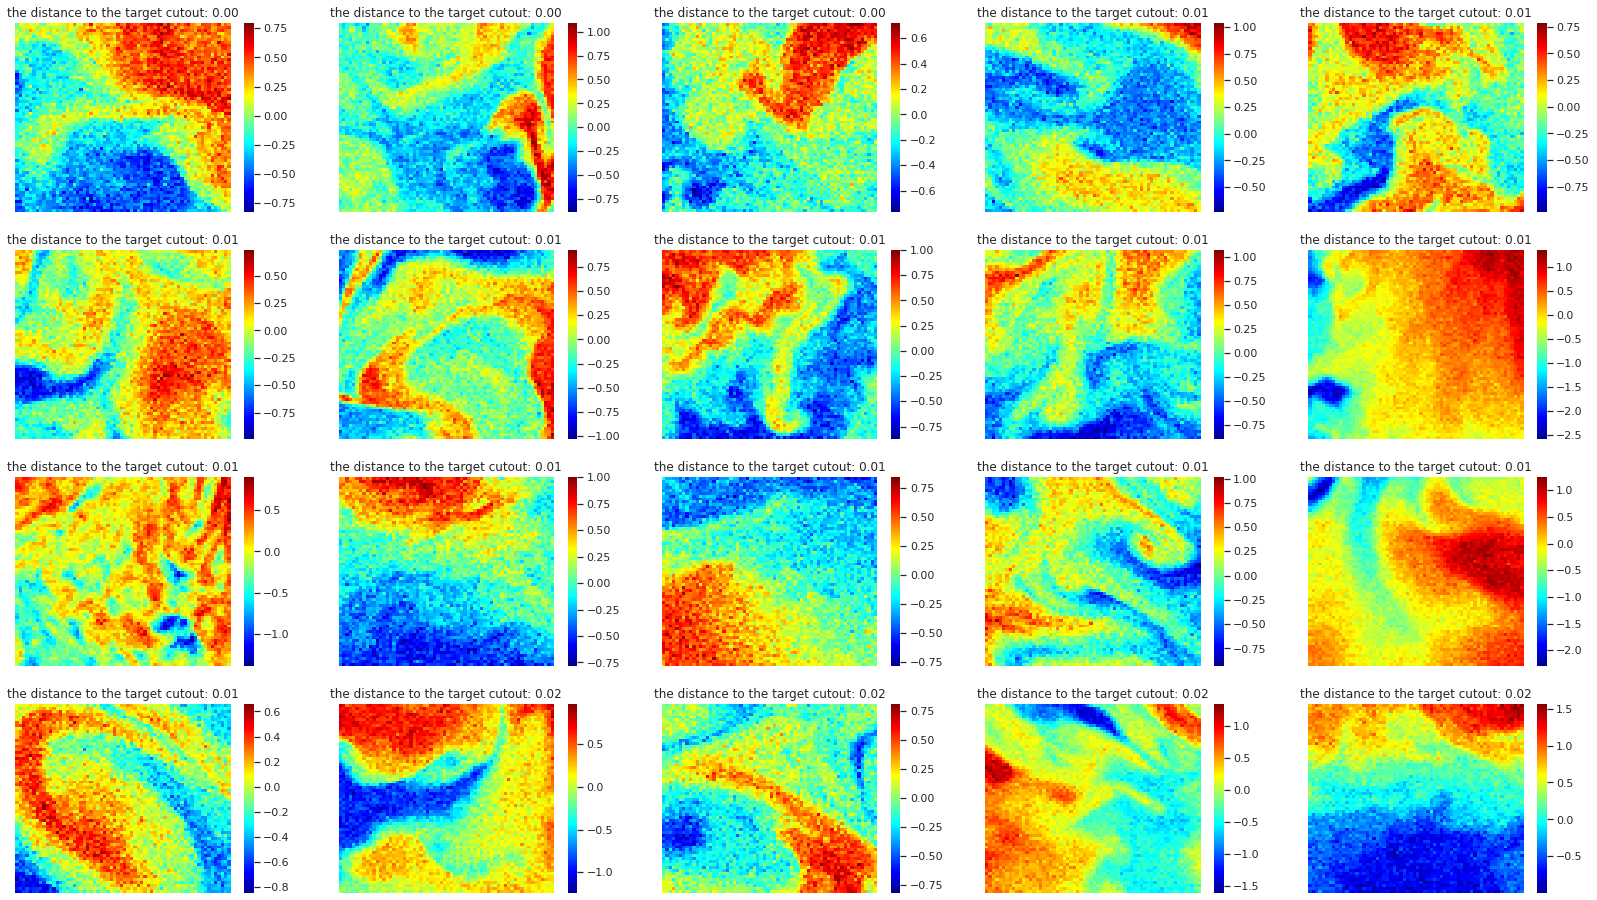

In [73]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')